In [1]:
import os
from transformers import MarianMTModel, MarianTokenizer, PegasusForConditionalGeneration, PegasusTokenizer

**model_name_translation** = "Helsinki-NLP/opus-mt-zh-en"

   **Purpose:**  
   - Specifies the name of the translation model.
   - "Helsinki-NLP/opus-mt-zh-en" is a model from the Helsinki-NLP group in the Hugging Face Transformers library.
   - opus-mt-zh-en indicates that the model is fine-tuned for translating from Chinese (zh) to English (en).

   **Why?:**
   - This string will be passed to Hugging Face’s `from_pretrained` method to load the pre-trained model and tokenizer.

**tokenizer_translation** = MarianTokenizer.from_pretrained(model_name_translation)

   **What It Does:**
   - Initializes a tokenizer for the MarianMT (Marian Machine Translation) model.
   - MarianTokenizer is a tokenizer designed specifically for MarianMT models. It:
     1. **Encodes Input Text:** Converts Chinese text into token IDs that the model understands.
     2. **Decodes Output Text:** Converts the model’s output token IDs back into readable English text.
   - The `from_pretrained(model_name_translation)` method loads the tokenizer’s vocabulary and configuration for this specific model (Helsinki-NLP/opus-mt-zh-en) from the Hugging Face model hub.

   **Why?:**
   - Tokenization is a crucial preprocessing step for any NLP model. For translation, the tokenizer ensures:
     - Chinese text is tokenized in a way that aligns with the model’s training.
     - The model can generate appropriate English text during decoding.

**model_translation** = MarianMTModel.from_pretrained(model_name_translation)

   **What It Does:**
   - Loads the pre-trained MarianMT model for Chinese-to-English translation.
   - MarianMTModel is a class specifically designed for MarianMT models in the Hugging Face Transformers library. It provides:
     - The encoder-decoder architecture required for translation tasks.
     - The model weights fine-tuned on Chinese-to-English translation data.

   **Why?:**
   - The `from_pretrained` method ensures that the exact architecture and weights corresponding to the Helsinki-NLP/opus-mt-zh-en model are loaded, so it can perform translations accurately.

In [2]:
# Define the model name
model_name_translation = "Helsinki-NLP/opus-mt-zh-en"

# Load the tokenizer and model
tokenizer_translation = MarianTokenizer.from_pretrained(model_name_translation)
model_translation = MarianMTModel.from_pretrained(model_name_translation)

#### MarianMTModel.from_pretrained(model_name_translation)

is responsible for loading the model weights into memory. Upon successful completion, it will trigger a `pytorch_model.bin` file to be stored **locally** on your computer.

When downloading a pre-trained model from Hugging Face's transformers library (or similar), the file is cached locally in your home directory at `~/.cache/huggingface/transformers/`. Within this directory, subdirectories are created for each model based on its name or repository.

If you specify a custom path when downloading or saving the model (e.g., `model.save_pretrained('custom_path')`), the file will be stored in that specified directory.

Once downloaded, the file remains on your disk and is reused whenever you load the model again, unless you manually delete it.

#### Managing Storage:

- **Clear Cache:** You can clear unused models from the cache if you need to free up space:
  ```bash
  huggingface-cli cache delete

- **Move to External Drive:**  You can also move the cache directory to an external drive or another location by setting the TRANSFORMERS_CACHE environment variable:
  ```bash
  export TRANSFORMERS_CACHE=/path/to/your/custom/location
  


In [3]:
# Example text to translate (Chinese)
text_to_translate = "你好，世界！"  # "Hello, world!"

# Preprocess: Tokenize the text
input_tokens = tokenizer_translation(text_to_translate, return_tensors="pt", padding=True, truncation=True)

# Translate: Generate predictions
translated_tokens = model_translation.generate(**input_tokens)

# Postprocess: Decode the output tokens to readable English
translated_text = tokenizer_translation.decode(translated_tokens[0], skip_special_tokens=True)

print(f"Translated text: {translated_text}")

Translated text: Hello, world!


model.safetensors:   0%|          | 0.00/312M [00:00<?, ?B/s]

In [15]:
translated_tokens[0]

tensor([65000,  3833,     2,   426,    48,     0])

In [9]:
# Input and output file paths
input_file = "../data/trial_text.txt"  # File containing Chinese text (one line per sentence)
output_file = "../data/translated_text.txt"  # File to save the English translations

# Read the input file and translate each line
try:
    with open(input_file, "r", encoding="utf-8") as infile, open(output_file, "w", encoding="utf-8") as outfile:
        for line in infile:
            # Remove leading/trailing whitespaces
            line = line.strip()

            # Skip empty lines
            if not line:
                continue

            # Tokenize the input text
            input_tokens = tokenizer_translation(line, return_tensors="pt", padding=True, truncation=True)

            # Generate translation
            translated_tokens = model_translation.generate(**input_tokens)

            # Decode the translated tokens to English text
            translated_text = tokenizer_translation.decode(translated_tokens[0], skip_special_tokens=True)

            # Write the translated text to the output file
            outfile.write(translated_text + "\n")

    print(f"Translation completed. Translated text saved to '{output_file}'.")
except Exception as e:
    print(f"An error occurred: {e}")

Translation completed. Translated text saved to '../data/translated_text.txt'.


`PEGASUS` (Pre-training with Extracted Gap-sentences for Abstractive Summarization) is a transformer model developed by Google.
	
The `xsum` fine-tuning makes it particularly suitable for generating single-sentence summaries.

The tokenizer converts input text into token IDs (numerical representations) that the model can understand.

In [4]:
# Define the model name
model_name_summary = "google/pegasus-xsum"

# Load the tokenizer and model
tokenizer_summary = PegasusTokenizer.from_pretrained(model_name_summary)
model_summary = PegasusForConditionalGeneration.from_pretrained(model_name_summary)

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
import timeit 
# Input file path
input_file = "../data/translated_text.txt"  # File containing text to summarize

# Function to summarize the text
def summarize_file():
    try:
        with open(input_file, "r", encoding="utf-8") as infile:
            for line in infile:
                # Strip leading/trailing whitespaces
                line = line.strip()

                # Skip empty lines
                if not line:
                    continue

                # Tokenize the input text
                inputs = tokenizer_summary(line, return_tensors="pt", max_length=1024, truncation=True)

                # Generate the summary
                summary_ids = model_summary.generate(inputs["input_ids"], max_length=50, min_length=10, length_penalty=2.0, num_beams=4, early_stopping=True)

                # Decode the summary and print it
                summary = tokenizer_summary.decode(summary_ids[0], skip_special_tokens=True)
                print(f"Original: {line}")
                print(f"Summary: {summary}")
                print("-" * 50)
    except Exception as e:
        print(f"An error occurred: {e}")

# Measure the execution time using timeit
execution_time = timeit.timeit(summarize_file, number=1)
print(f"Total Execution Time: {execution_time:.2f} seconds")

Original: League of Nations securities: investing in business as an important growth point in the transformation of wealth management operations
Summary: In our series of letters from African journalists, filmmaker and columnist Ahmedou Ould-Abdallah looks at some of the key stories of the week in the world of finance.
--------------------------------------------------
Original: The party's 20-year report stresses that “common wealth is the essence of socialism in China’s identity.” The management of wealth, as an important hub for the allocation of capital elements, has a direct impact on the property income of the population and plays an important role in promoting common wealth. Exploring trends in wealth management operations, optimizing the distribution of wealth among the population, and achieving the preservation, value addition and transmission of the wealth of the population, is the driving force and historical mission of the wealth management bodies.
Summary: The Communist Pa

In [7]:
import textwrap
import timeit

# Input file path
input_file = "../data/translated_text.txt"  # File containing text to summarize

# Function to reorganize the text into paragraphs
def reorganize_text(text, max_length=1024):
    # Remove excessive whitespace and split into sentences
    sentences = text.split(". ")
    paragraph = ""
    paragraphs = []

    for sentence in sentences:
        # Add sentence to the current paragraph
        if len(paragraph) + len(sentence) + 2 <= max_length:  # +2 accounts for ". " separator
            paragraph += sentence.strip() + ". "
        else:
            # Save the current paragraph and start a new one
            paragraphs.append(paragraph.strip())
            paragraph = sentence.strip() + ". "

    # Add the last paragraph if not empty
    if paragraph.strip():
        paragraphs.append(paragraph.strip())

    return paragraphs

# Function to summarize the text
def summarize_file():
    try:
        with open(input_file, "r", encoding="utf-8") as infile:
            raw_text = infile.read()

        # Reorganize the text into paragraphs
        paragraphs = reorganize_text(raw_text)

        # Summarize each paragraph
        for paragraph in paragraphs:
            # Tokenize the input text
            inputs = tokenizer_summary(paragraph, return_tensors="pt", max_length=1024, truncation=True)

            # Generate the summary
            summary_ids = model_summary.generate(
                inputs["input_ids"], 
                max_length=50, 
                min_length=10, 
                length_penalty=2.0, 
                num_beams=4, 
                early_stopping=True
            )

            # Decode the summary and print it
            summary = tokenizer_summary.decode(summary_ids[0], skip_special_tokens=True)
            print(f"Original: {paragraph}")
            print(f"Summary: {summary}")
            print("-" * 50)
    except Exception as e:
        print(f"An error occurred: {e}")

# Measure the execution time using timeit
execution_time = timeit.timeit(summarize_file, number=1)
print(f"Total Execution Time: {execution_time:.2f} seconds")

Original: League of Nations securities: investing in business as an important growth point in the transformation of wealth management operations
The party's 20-year report stresses that “common wealth is the essence of socialism in China’s identity.” The management of wealth, as an important hub for the allocation of capital elements, has a direct impact on the property income of the population and plays an important role in promoting common wealth. Exploring trends in wealth management operations, optimizing the distribution of wealth among the population, and achieving the preservation, value addition and transmission of the wealth of the population, is the driving force and historical mission of the wealth management bodies.
In 2022, the country's wealth chain generated $1.5 trillion, based on reports from China, which generated income of $500 million, $70.71 billion, $614.5 billion, $75.8 billion, $111.4 billion, respectively, from investment, sales and capital management.
Summary:

In [6]:
import timeit
# Input file path
input_file = "../data/translated_text.txt"  # File containing text to summarize
# Function to summarize the text
def summarize_file():
    try:
        with open(input_file, "r", encoding="utf-8") as infile:
            raw_text = infile.read()

        # Reorganize the text into paragraphs
        paragraphs = reorganize_text(raw_text)

        # Initialize a list to hold all summaries
        all_summaries = []

        # Summarize each paragraph
        for paragraph in paragraphs:
            # Tokenize the input text
            inputs = tokenizer_summary(paragraph, return_tensors="pt", max_length=1024, truncation=True)

            # Generate the summary
            summary_ids = model_summary.generate(
                inputs["input_ids"], 
                max_length=50, 
                min_length=10, 
                length_penalty=2.0, 
                num_beams=4, 
                early_stopping=True
            )

            # Decode the summary
            summary = tokenizer_summary.decode(summary_ids[0], skip_special_tokens=True)
            
            # Append the summary to the list
            all_summaries.append(summary)

        # Combine all summaries into a single piece
        combined_summary = " ".join(all_summaries)

        # Print the combined summary
        print("Combined Summary:")
        print(combined_summary)
        print("-" * 50)

        # Return the combined summary for further use
        return combined_summary

    except Exception as e:
        print(f"An error occurred: {e}")

# Measure the execution time using timeit
execution_time = timeit.timeit(summarize_file, number=1)
print(f"Total Execution Time: {execution_time:.2f} seconds")

An error occurred: name 'reorganize_text' is not defined
Total Execution Time: 0.00 seconds


Matplotlib is building the font cache; this may take a moment.


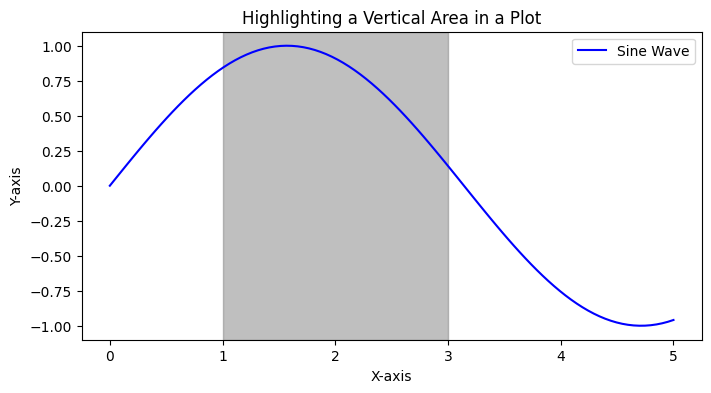

In [11]:
from langchain_ollama.llms import OllamaLLM
llm = OllamaLLM(model="llama3.2:1b")


# Attempt to invoke the model with error handling
try:
    response = llm.invoke('what is love')  # Changed input format
    print(response)
except Exception as e:
    print(f"An error occurred: {e}")

An error occurred: 


In [12]:
# Import the necessary library
from langchain_ollama.llms import OllamaLLM

# Initialize the model
llm = OllamaLLM(model="llama3.2:1b")

# Define a function to invoke the model
def invoke_llm(prompt):
    try:
        # Invoke the model with the given prompt
        response = llm.invoke(prompt)
        return response
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

# Example usage
if __name__ == "__main__":
    prompt = "What is love?"
    result = invoke_llm(prompt)
    if result:
        print(f"Response: {result}")

An error occurred: 
